In [1]:
%matplotlib inline
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
from databasing.conn_strings import db_conn_string
import matplotlib.pyplot as plt

conn = create_engine(db_conn_string)

In [2]:
lid = 134
sql_ord = 'SELECT * FROM lift_data WHERE lift_id = {} ORDER BY timepoint ASC'.format(lid)
dat_ord = pd.read_sql(sql_ord, conn)
dat_ord['m_adj'] = dat_ord['millis'] - dat_ord['millis'].min()
dat_ord.head()

,lift_id,a_x,a_y,a_z,timepoint,g_x,g_y,g_z,millis,m_adj
0,134,0.0,0.0,0.0,0.000000,-0.09,-0.03,0.06,681437,0
1,134,0.0,0.0,0.0,0.033333,-0.08,-0.09,0.07,681452,15
2,134,0.0,0.0,0.0,0.066667,-0.07,-0.01,0.08,681468,31
3,134,0.0,0.0,0.0,0.100000,-0.02,-0.08,-0.04,681484,47
4,134,0.0,0.0,0.0,0.133333,0.05,-0.08,0.03,681506,69


In [3]:
sql = 'SELECT * FROM lift_data WHERE lift_id = {}'.format(lid)
dat = pd.read_sql(sql, conn)
dat['m_adj'] = dat['millis'] - dat['millis'].min()

/anaconda/envs/fitai/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.
/anaconda/envs/fitai/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


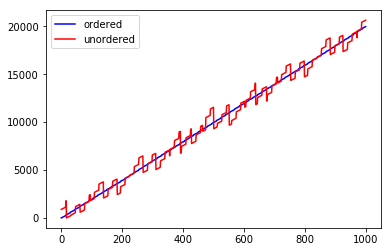

In [4]:
plt.plot(dat_ord['m_adj'].ix[:1000], color='b', label='ordered')
plt.plot(dat['m_adj'].ix[:1000], color='r', label='unordered')
plt.legend()

In [5]:
from databasing.database_pull import pull_data_by_lift
from processing.util import process_data
header, data = pull_data_by_lift(lid)

a, v, pwr, pos, force = process_data(header, data, RMS=False)

In [6]:
def max_min_norm(s):
    return s/(s.max() - s.min())

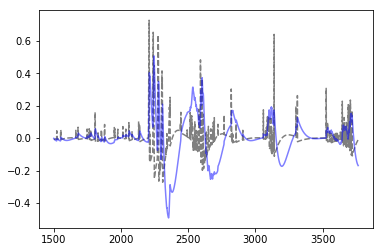

In [14]:
a['ay_norm'] = max_min_norm(a['a_y'])
v['vx_norm'] = max_min_norm(v['v_x'])
v['vy_norm'] = max_min_norm(v['v_y'])
v['vz_norm'] = max_min_norm(v['v_z'])

# plot a subset
min_idx = 1500

# plt.plot(a['a_y'], color='black', alpha=0.5)
plt.plot(a['ay_norm'].iloc[min_idx:], color='black', alpha=0.5, linestyle='--')
# plt.plot(v['v_y'], color='blue', linestyle='--', alpha=0.5)
plt.plot(v['vy_norm'].iloc[min_idx:], color='blue', alpha=0.5)

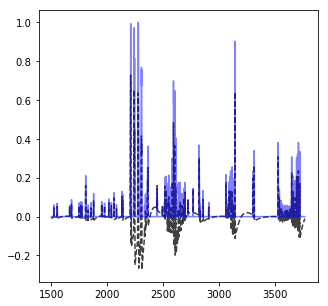

In [19]:
dat_ord['ay_norm'] = max_min_norm(dat_ord['a_y'])

plt.figure(figsize=(5,5))
plt.plot(a['ay_norm'].iloc[min_idx:], color='black', alpha=0.75, linestyle='--')
plt.plot(dat_ord['ay_norm'].iloc[min_idx:], color='blue', alpha=0.5)

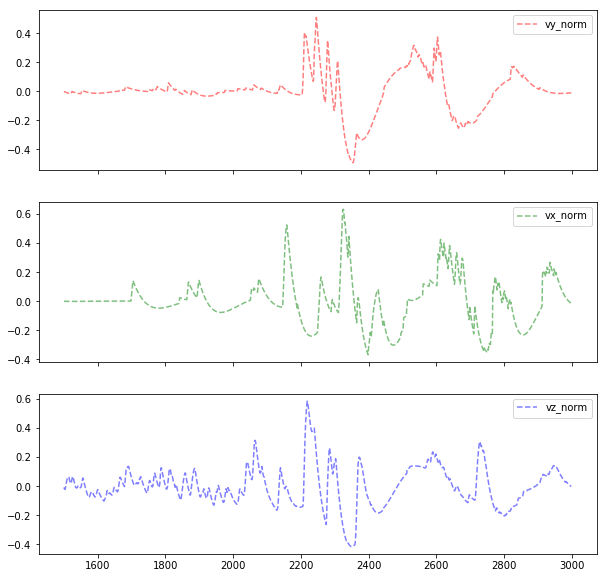

In [22]:
colors = ['red', 'green', 'blue']
norm_keys = [k for k in v.keys() if '_norm' in k]
fig, axarr = plt.subplots(3, sharex=True, figsize=(10, 10))
for i, (c, lab) in enumerate(zip(colors, norm_keys)):
    axarr[i].plot(v[lab].iloc[min_idx:2*min_idx], color=c, alpha=0.5, linestyle='--', label=lab)
    axarr[i].legend()